In [1]:
import numpy as np
from functools import reduce
import dask
import dask.bag as dbag
from distributed import Client

from mereldet import (
    Optimizer,
    function_under_test,
    MUT_SCALE,
    CostFunction,
    MRCandidate,
)
from matplotlib import pyplot as plt


In [2]:
# start dask cluster
client = Client(n_workers=16, threads_per_worker=1)
client

2022-11-02 16:58:56,778 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/65/wr102h8j6wz_gdytvslzntvwrql040/T/dask-worker-space/worker-zzlza5z9', purging
2022-11-02 16:58:56,782 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/65/wr102h8j6wz_gdytvslzntvwrql040/T/dask-worker-space/worker-m5g_q7yw', purging
2022-11-02 16:58:56,783 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/65/wr102h8j6wz_gdytvslzntvwrql040/T/dask-worker-space/worker-u3_fv8ad', purging
2022-11-02 16:58:56,785 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/65/wr102h8j6wz_gdytvslzntvwrql040/T/dask-worker-space/worker-saays_rw', purging
2022-11-02 16:58:56,787 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/65/wr102h8j6wz_gdytvslzntvwrql040/T/dask-worker-space/worker-zlk36m0g', purging
2022-11-02 16:58:56,790 - distributed.diskutils - INFO - Found st

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62206,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:62278,Total threads: 1
Dashboard: http://127.0.0.1:62280/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:62220,


# Cost functions

The default formulation of the cost function as formulated in this [short paper](https://doi.org/10.1109/MET52542.2021.00014) has several drawbacks that may prevent optimization towards a metamorphic relation, i.e. to minimize $\|f(g(x)) - f(x)\|$:

- The optimizer is able to minimize the cost arbitrarily by maximizing the regularization factor $\frac{1}{\epsilon + \prod_{g_n\in G} \|g_n(x) - g(x)\|^2}$
- by using the product of squared distances to all previously identified MRs, $g$ might still be very close to a single element of $G$ but this may be masked by large distances to all other elements of $G$
- The nominator and denominator of the default cost function may have different scales and the scale of the denominator changes with the set $G$

Hence, alternative formulations for the cost function are proposed and their influence on the ability to minimize the target $\|f(g(x)) - f(x)\|$ is investigated.


| Identifier | Formulation |
|------------|-------------|
| default    | $\frac{1}{N} \sum_{x\in X} \frac{\|f(g(x)) - f(x)\|}{\epsilon + \prod_{g_n\in G} \|g_n(x) - g(x)\|^2}$ |
| reg        | $\frac{1}{N} \sum_{x\in X} \|f(g(x)) - f(x)\|(1 + \frac{\alpha}{\prod_{g_n\in G} \|g_n(x) - g(x)\|^2})$ |
| min_reg    | $\frac{1}{N} \sum_{x\in X} \|f(g(x)) - f(x)\|(1 + \frac{\alpha}{\min_{g_n\in G} \|g_n(x) - g(x)\|^2})$ | 
| reg_sum    | $\frac{1}{N} \sum_{x\in X} \|f(g(x)) - f(x)\|+ \frac{\alpha}{\prod_{g_n\in G} \|g_n(x) - g(x)\|^2}$ |

In [3]:
class Default(CostFunction):
    name = "default"

    def eval(self, input: np.ndarray, candidate: MRCandidate) -> float:
        return super().eval(input, candidate) / input.shape[0]


class Reg(CostFunction):
    name = "reg"

    def __init__(self, *args, alpha=1e-5, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha

    def eval(self, input: np.ndarray, candidate: MRCandidate) -> float:
        morph_in = candidate(input)
        dist = self.distance_in_codomain(input, candidate)
        regularization = 1 + self.alpha / reduce(
            np.multiply,
            map(
                lambda g: ((morph_in - g(input)) ** 2).sum(axis=-1),
                self.morph_relations,
            ),
        )
        cost = (dist * regularization).mean()
        return cost


class MinReg(Reg):
    name = "min_reg"

    def eval(self, input: np.ndarray, candidate: MRCandidate) -> float:
        morph_in = candidate(input)
        dist = self.distance_in_codomain(input, candidate)
        regularization = 1 + self.alpha / reduce(
            np.minimum,
            map(
                lambda g: ((morph_in - g(input)) ** 2).sum(axis=-1),
                self.morph_relations,
            ),
        )
        cost = (dist * regularization).mean()
        return cost

class Sum(Reg):
    name = "sum"

    def eval(self, input: np.ndarray, candidate: MRCandidate) -> float:
        morph_in = candidate(input)
        dist = self.distance_in_codomain(input, candidate)
        regularization = self.alpha / reduce(
            np.multiply,
            map(
                lambda g: ((morph_in - g(input)) ** 2).sum(axis=-1),
                self.morph_relations,
            ),
        )
        cost = (dist + regularization).mean()
        return cost


In [4]:
def create_training_data(n=10_000, size=2, scale: float=1., rng: np.random.Generator=np.random.default_rng(seed=1234)):
    return scale * rng.uniform(low=-1, high=1, size=(n, size))

# Experiment with Function under test `prod`

In [5]:
input_scale=10.0
input_size=10_000
repetitions=20
timeout = 10_000


In [6]:
def binop_sum(a, b):
    res = {}
    for k in a.keys():
        if k == "name" or k.endswith("_sq"):
            continue
        res[k] = a[k] + b[k]
        res[f"{k}_sq"] = np.sqrt(a[k] ** 2 + b[k] ** 2)
    return res


def compute_stats(x):
    name = x[0]
    quantites = [k for k in x[1].keys() if not k.endswith("_sq")]
    res = dict(name=name)
    for q in quantites:
        res[q] = x[1][q] / repetitions
        var = (x[1][f"{q}_sq"] ** 2) / (repetitions - 1) - res[q]**2 * repetitions / (
            repetitions - 1
        )
        res[f"{q}_stderr"] = np.sqrt(var / repetitions)
    return res


def run_convergence_experiment(function_under_test=function_under_test["prod"]):
    def optimize(input):
        n, c_func = input
        rng = np.random.default_rng(seed=n)
        optimizer = Optimizer(
            c_func,
            create_training_data(input_size, scale=input_scale, rng=rng),
            rng=rng,
        )
        _ = optimizer.optimize(mut_scale=MUT_SCALE, timeout=timeout)
        return dict(
            name=c_func.name,
            cost=np.array(optimizer.trace["cost"]),
            mean_dist=np.array(optimizer.trace["mean_dist"]),
        )

    cost_functions = [
        Default(function_under_test, [MRCandidate.from_identity()]),
        Reg(function_under_test, [MRCandidate.from_identity()], alpha=1e-5),
        MinReg(function_under_test, [MRCandidate.from_identity()], alpha=1e-5),
        Sum(function_under_test, [MRCandidate.from_identity()], alpha=1e-5),
    ]

    params = dbag.from_sequence(
        [(n, c_func) for c_func in cost_functions for n in range(repetitions)]
    )

    return (
        params.map(optimize)
        .foldby(lambda x: x["name"], binop_sum)
        .map(compute_stats)
        .compute()
    )


def plot_convergence_experiment(final_result):
    for quant in ["cost", "mean_dist"]:
        for r in final_result:
            plt.loglog(r[quant], label=f"{quant} {r['name']}")
            plt.fill_between(
                x=range(timeout),
                y1=r[quant] - r[quant + "_stderr"],
                y2=r[quant] + r[quant + "_stderr"],
                alpha=0.3,
            )
    plt.xlabel("Iteration count")
    plt.legend()


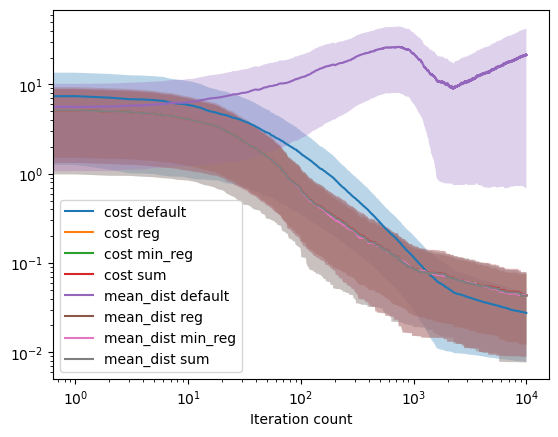

In [7]:
plot_convergence_experiment(run_convergence_experiment(function_under_test["prod"]))

## Test dependence on regularization constant $\alpha$

In [10]:
def hyper_parameter_sensitivity_experiment(
    function_under_test=function_under_test["prod"],
):
    def optimize(input):
        n, c_func_class, alpha = input
        rng = np.random.default_rng(seed=n)
        c_func = c_func_class(
            function_under_test, [MRCandidate.from_identity()], alpha=alpha
        )
        optimizer = Optimizer(
            c_func,
            create_training_data(input_size, scale=input_scale, rng=rng),
            rng=rng,
        )
        _ = optimizer.optimize(mut_scale=MUT_SCALE, timeout=timeout)
        return dict(
            name=f"{c_func.name} {alpha:4.1e}",
            cost=np.array(optimizer.trace["cost"]),
            mean_dist=np.array(optimizer.trace["mean_dist"]),
        )

    params = dbag.from_sequence(
        [
            (n, c_func, alpha)
            for c_func in [Reg, MinReg, Sum]
            for alpha in [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
            for n in range(repetitions)
        ]
    )

    return (
        params.map(optimize)
        .foldby(lambda x: x["name"], binop_sum)
        .map(compute_stats)
        .compute()
    )


def plot_hyper_parameter_sensitivity(final_result):
    plt.figure(figsize=(12, 4))
    for i, cf in enumerate(["reg", "min_reg", "sum"]):
        plt.subplot(1, 3, i + 1)
        plt.title(f"{cf} mean_dist")
        plt.xlabel("Iteration count")
        for r in final_result:
            if not r["name"].startswith(cf):
                continue
            plt.loglog(r["mean_dist"], label=f"{r['name'].split(' ')[1]}")
            plt.fill_between(
                x=range(timeout),
                y1=r["mean_dist"] - r["mean_dist_stderr"],
                y2=r["mean_dist"] + r["mean_dist_stderr"],
                alpha=0.3,
            )
        plt.legend()


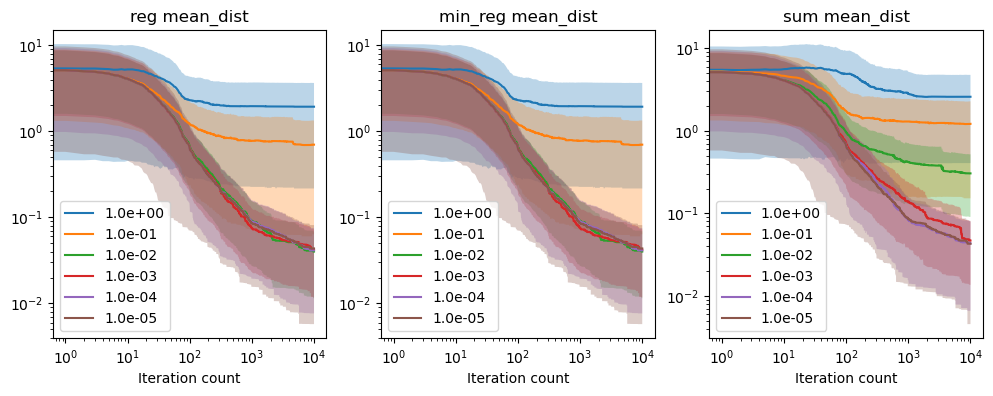

In [11]:
plot_hyper_parameter_sensitivity(
    hyper_parameter_sensitivity_experiment(function_under_test["prod"])
)


# Conclusion
- The cost function `default` is not able to optimize the mean distance between the results of the function under test of the morphed and original input.
- Both proposed cost functions, `reg` and `min_reg`, are able to optimize for the mean distance. However, their ability depends on the new hyperparameter $\alpha$.
- Both `reg` and `min_reg` are very similar on average, but `min_reg` shows larger variance.
- For this function under test and input data scale, a good choice for $\alpha$ seems to be `1e-2` and smaller.
- The value of $\alpha$ depends on the scale of the regularization term compared to the mean distance and the strength of the desired regularization.

# Repeating experiment with function under test `sum` 

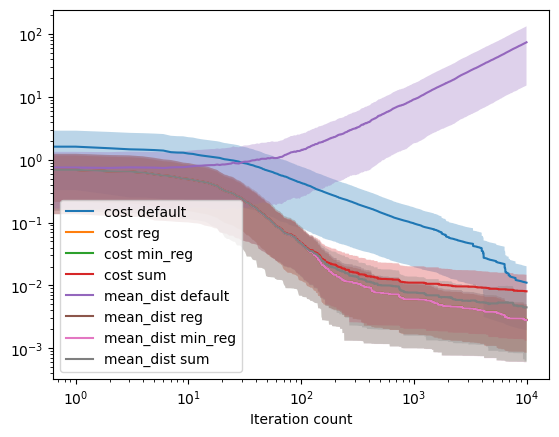

In [12]:
plot_convergence_experiment(run_convergence_experiment(function_under_test["sum"]))

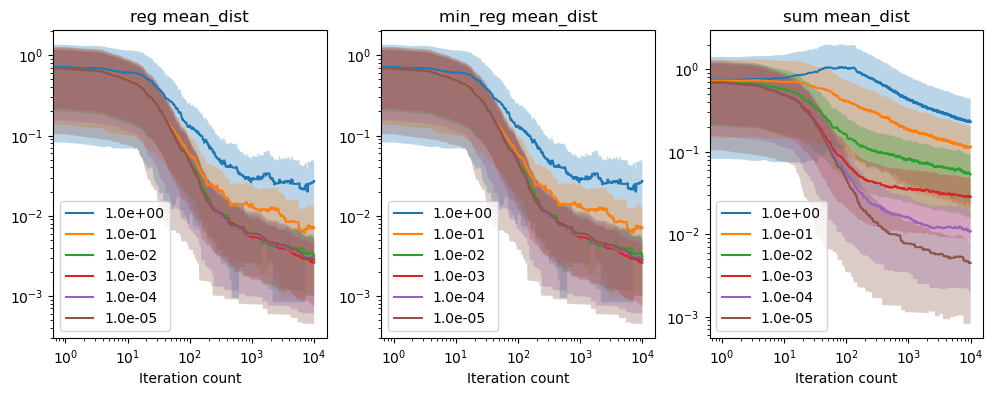

In [13]:
plot_hyper_parameter_sensitivity(
    hyper_parameter_sensitivity_experiment(function_under_test["sum"])
)
